<a href="https://colab.research.google.com/github/shubhamksingh1/TimeSeries/blob/main/AppliedTimeSeriesAnalysisWithPython/AppliedTimeSeriesAnalysisWithPython_HOTSAP_VAR_VARMA_VARMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels==0.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# VAR

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
plt.rcParams['figure.figsize'] = [10, 7.5]

## United States Macroeconomic Dataset

In [ ]:
macro_data = sm.datasets.macrodata.load_pandas()
macro_data = macro_data.data
macro_data.head()


,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


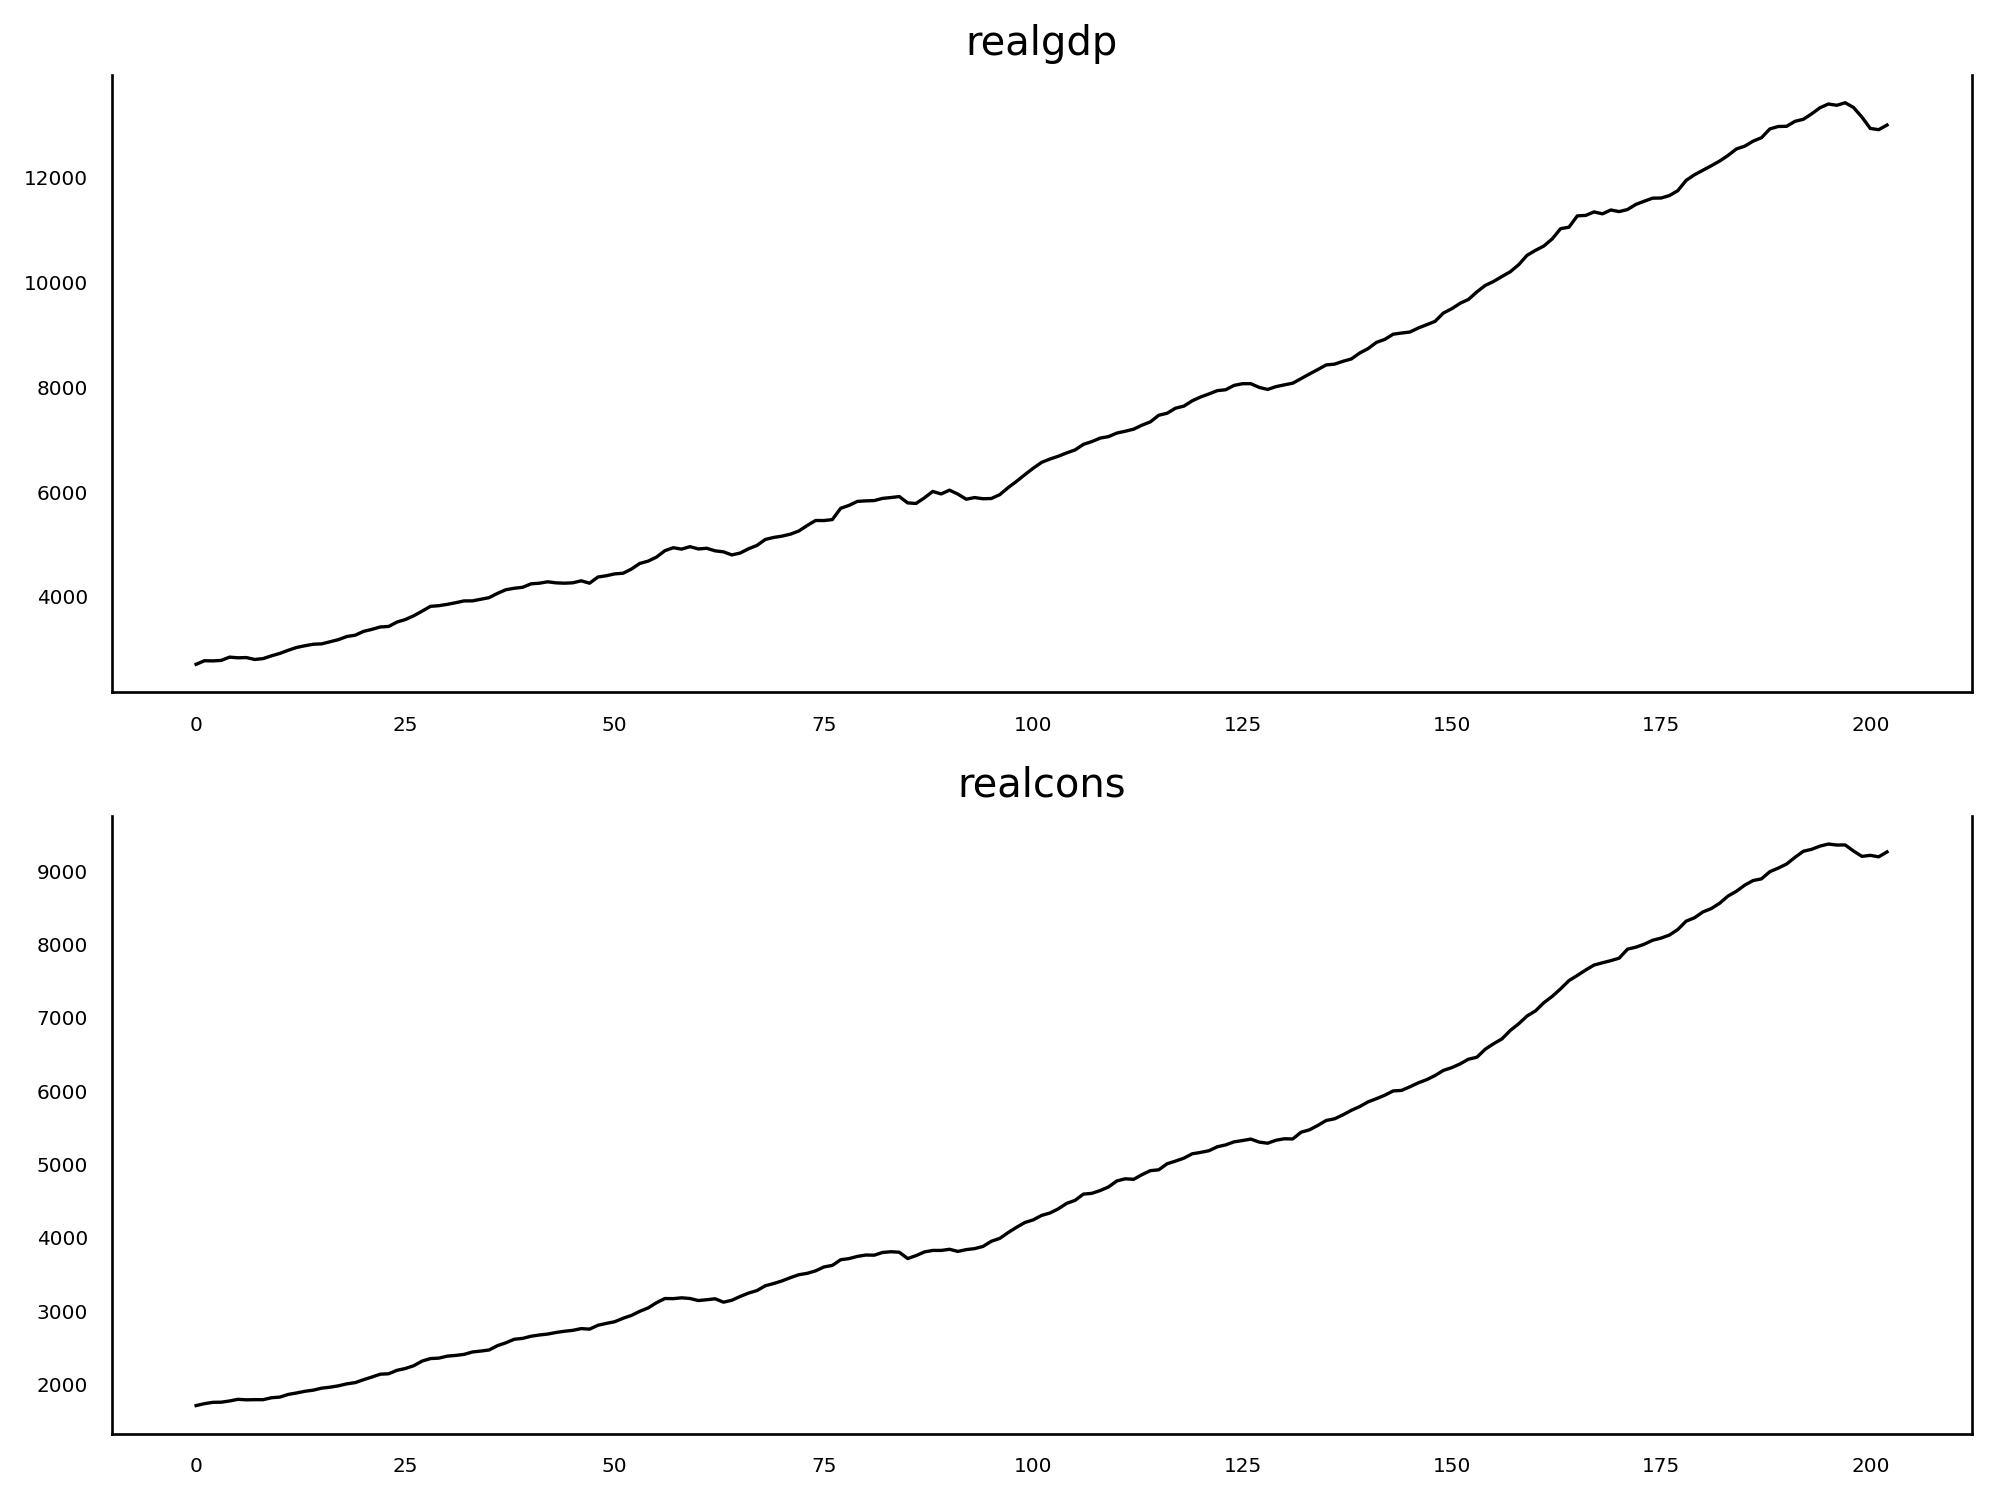

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color='black', linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'], color='black', linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

In [ ]:
ad_fuller_result_1 = adfuller(macro_data['realgdp'].diff()[1:])

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realgdp
ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08

---------------------

realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


p value less than 0.05 so one time differencing make both series stationary

In [ ]:
def optimize_VAR(endog):
    """
        Returns a dataframe with parameters and corresponding MSE
        
        endog - observed time series
    """
    
    results = []
    
    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        mse = model.mse
        results.append([i, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
endog = macro_data[['realgdp', 'realcons']]

result_df = optimize_VAR(endog)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,mse
0,11,1.455647e+05
1,12,1.503687e+05
2,10,1.518824e+05
3,13,1.528851e+05
4,9,1.617206e+05
5,7,1.659521e+05
6,6,1.709638e+05
7,8,1.733337e+05
8,5,1.769040e+05
9,4,2.044782e+05


In [ ]:
best_model = VARMAX(endog, order=(11,0))
res = best_model.fit(disp=False)
print(res.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                             VAR(11)   Log Likelihood               -1985.715
                               + intercept   AIC                           4069.430
Date:                     Wed, 22 Jun 2022   BIC                           4231.778
Time:                             12:45:02   HQIC                          4135.110
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.11   Jarque-Bera (JB):           4.54, 8.94
Prob(Q):                        0.91, 0.74   Prob(JB):                   0.10, 0.01
Heteroskedasticity (H):         1.86, 2.46   Skew:                       0.3

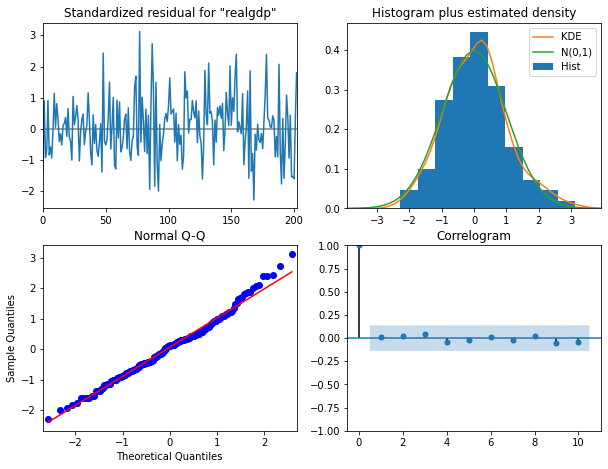

In [ ]:
res.plot_diagnostics();

In [ ]:
n_forecast = 3
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

predict.predicted_mean.tail(3)

,realgdp,realcons
204,13161.923020,9292.380745
205,13189.066897,9293.346649
206,13228.622640,9293.811645


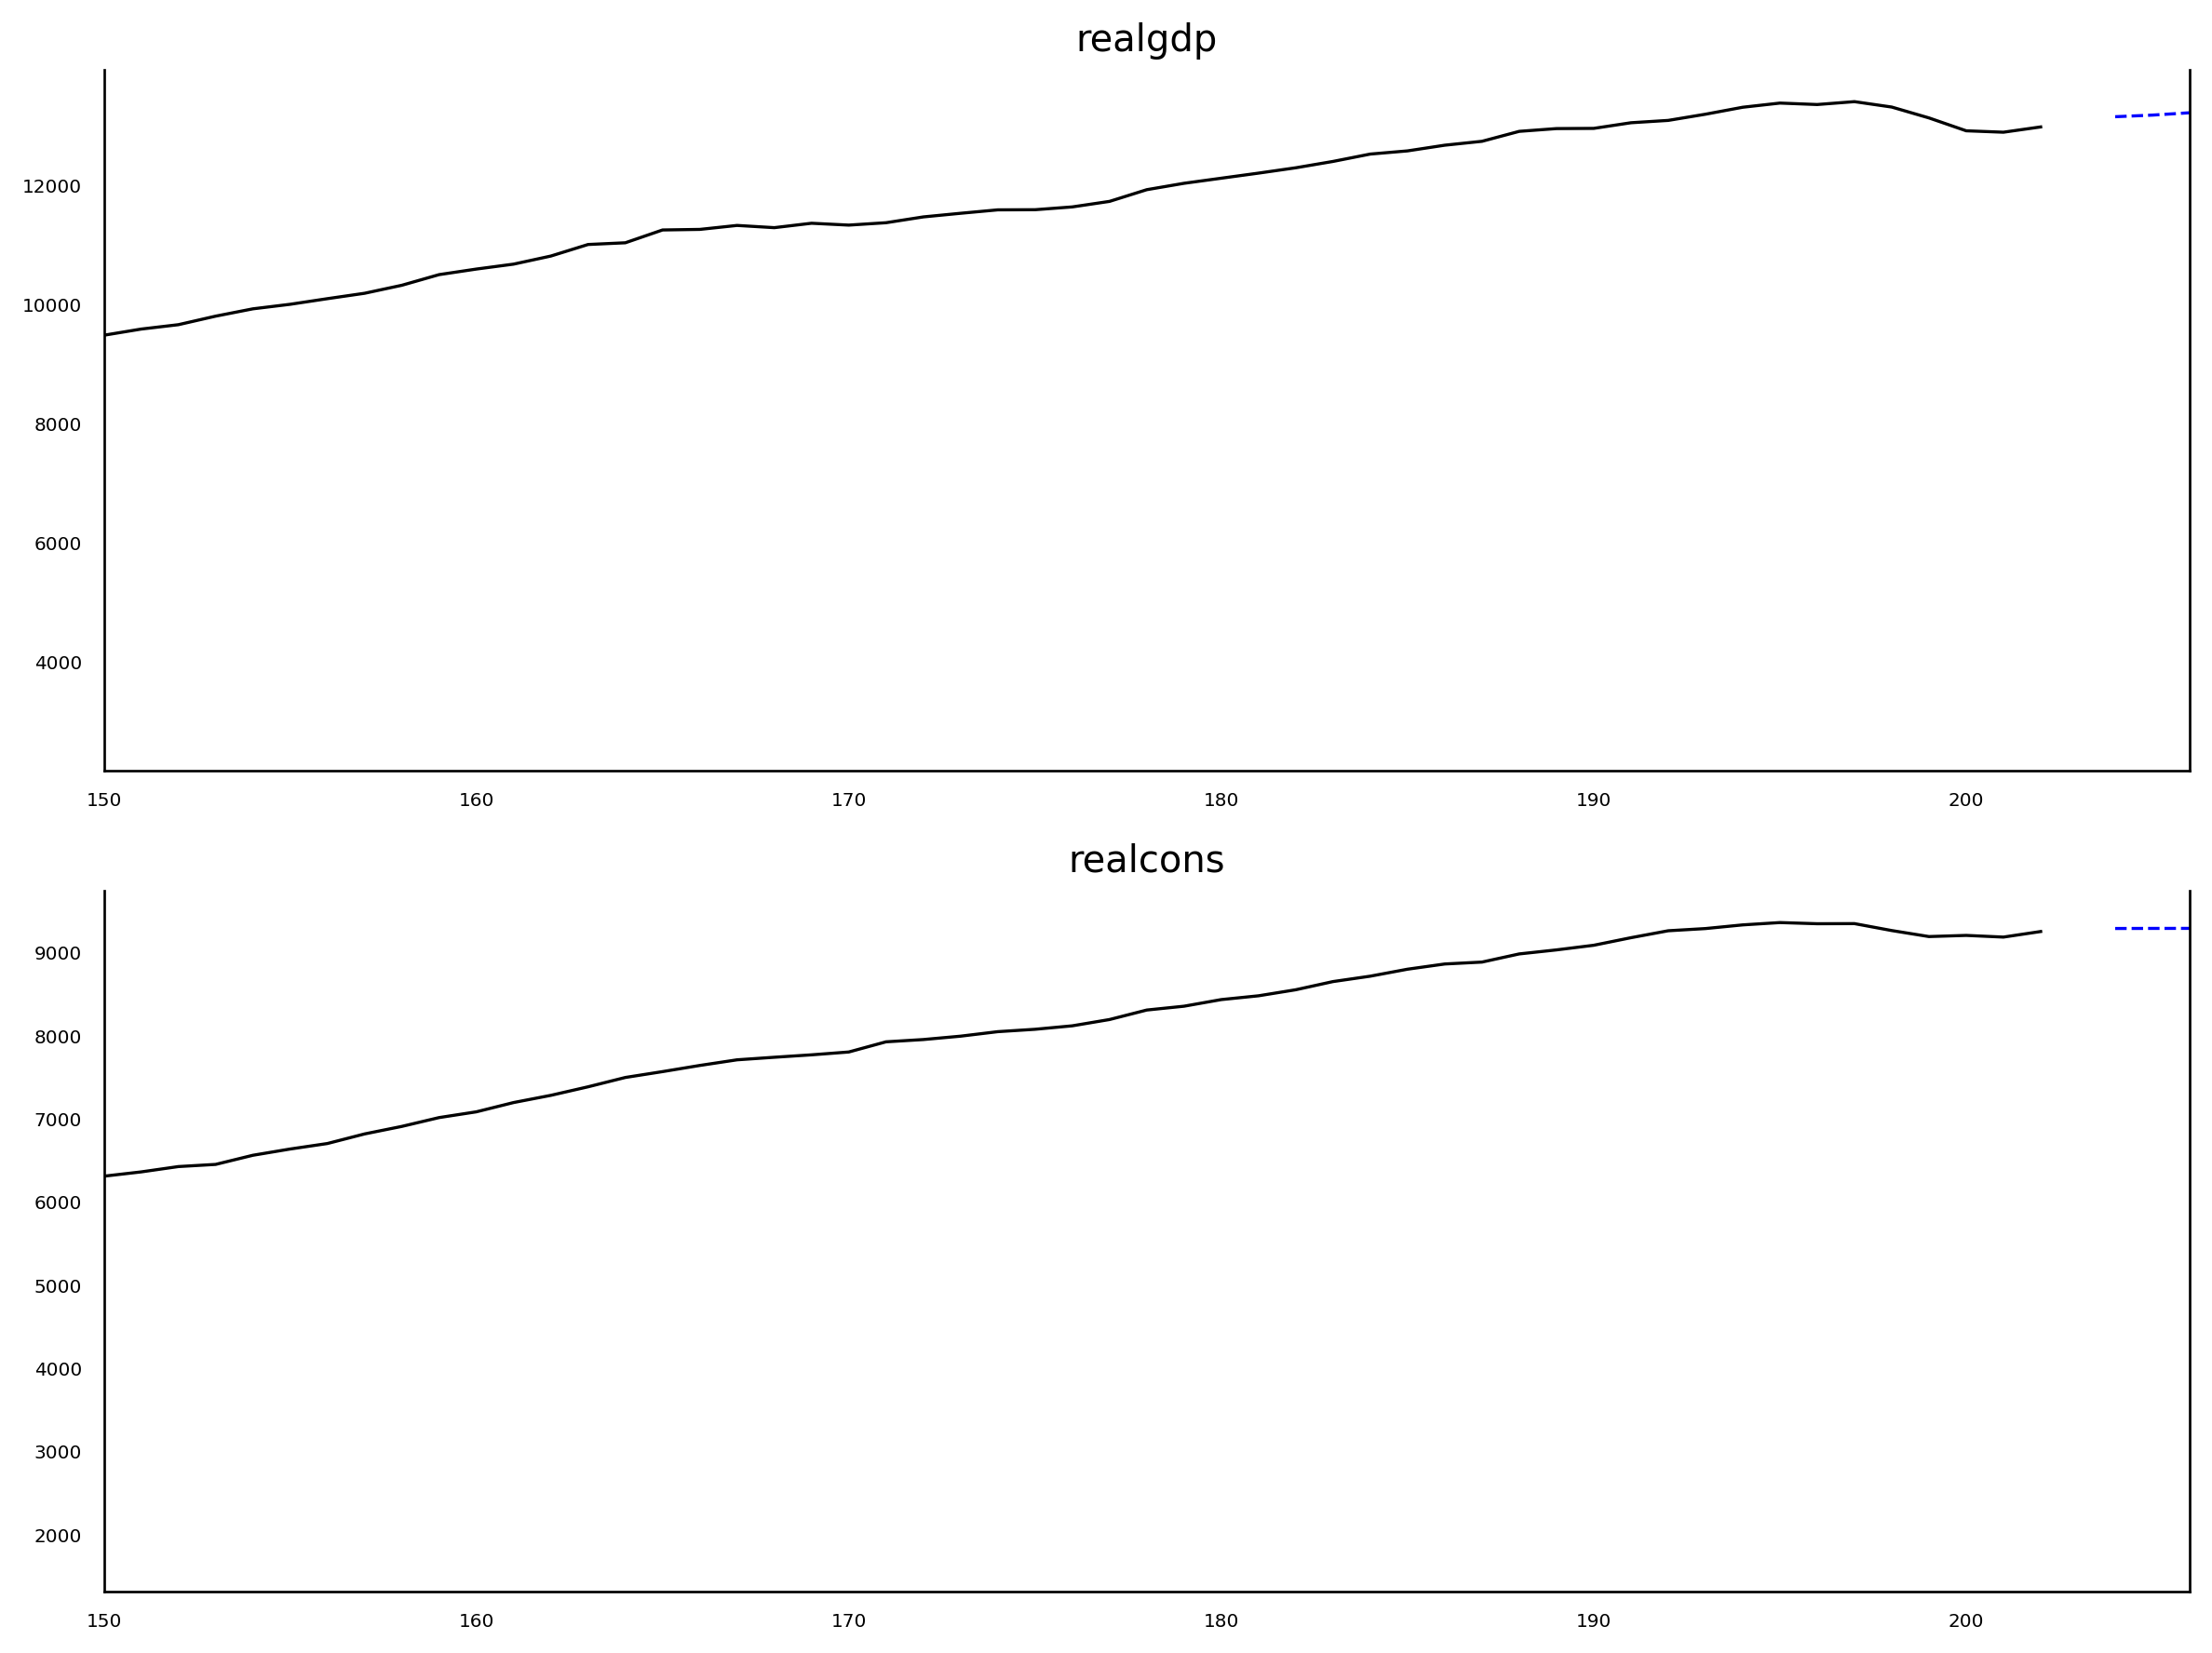

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color='black', linewidth=1)
ax1.plot(idx[-n_forecast:], 
         predict.predicted_mean['realgdp'][-n_forecast:], 
         color='blue', 
         ls='--',
         linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150, 206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'], color='black', linewidth=1)
ax2.plot(idx[-n_forecast:], 
         predict.predicted_mean['realcons'][-n_forecast:], 
         color='blue', 
         ls='--',
         linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
print('realcons causes realgdp?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_data[['realgdp', 'realcons']].diff()[1:], [11])

print('\nrealgdp causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_data[['realcons', 'realgdp']].diff()[1:], [11])

realcons causes realgdp?

------------------

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=6.7078  , p=0.0000  , df_denom=168, df_num=11
ssr based chi2 test:   chi2=83.8875 , p=0.0000  , df=11
likelihood ratio test: chi2=69.5409 , p=0.0000  , df=11
parameter F test:         F=6.7078  , p=0.0000  , df_denom=168, df_num=11

realgdp causes realcons?

------------------

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.8223  , p=0.0537  , df_denom=168, df_num=11
ssr based chi2 test:   chi2=22.7899 , p=0.0189  , df=11
likelihood ratio test: chi2=21.5296 , p=0.0283  , df=11
parameter F test:         F=1.8223  , p=0.0537  , df_denom=168, df_num=11


* all p values less than equals 0.5 for granger_1 so realcons causes realgdp
* all p values less than equals 0.5 for granger_2 so realgdp causes realcons

# VARMA

In [ ]:
def optimize_VARMA(endog, parameters_list):
    """
        Returns a dataframe with parameters (p,d) and corresponding MSE
        
        endog - the observed variable
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order=param).fit(disp=False)
        except:
            continue
    
        mse = model.mse
        results.append([param, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
endog = macro_data[['realgdp', 'realcons']]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters = product(p, q)
parameters_list = list(parameters)

result_df_VARMA = optimize_VARMA(endog, parameters_list)
result_df_VARMA

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",mse
0,"(1, 1)",1.464948e+05
1,"(3, 1)",1.699557e+05
2,"(3, 2)",1.739604e+05
3,"(3, 3)",2.055813e+05
4,"(3, 0)",3.088912e+05
5,"(0, 1)",5.719520e+05
6,"(2, 1)",5.780148e+05
7,"(1, 2)",6.563652e+05
8,"(0, 3)",9.097261e+05
9,"(1, 3)",1.245810e+06


In [ ]:
best_model_VARMA = VARMAX(endog, order=(1,1))
res_VARMA = best_model.fit(disp=False)
print(res_VARMA.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                             VAR(11)   Log Likelihood               -1985.715
                               + intercept   AIC                           4069.430
Date:                     Wed, 22 Jun 2022   BIC                           4231.778
Time:                             12:52:46   HQIC                          4135.110
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.11   Jarque-Bera (JB):           4.54, 8.94
Prob(Q):                        0.91, 0.74   Prob(JB):                   0.10, 0.01
Heteroskedasticity (H):         1.86, 2.46   Skew:                       0.3

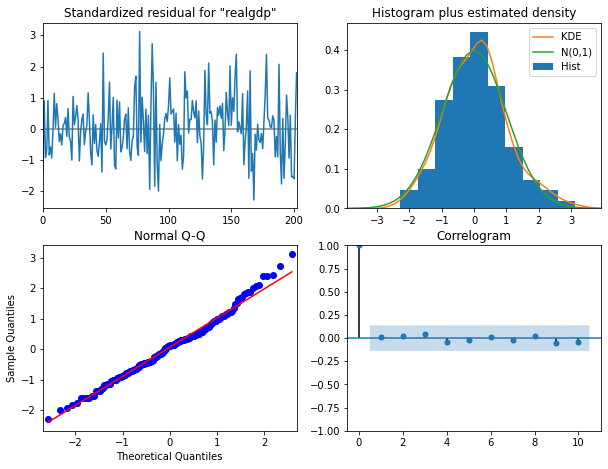

In [ ]:
res_VARMA.plot_diagnostics();

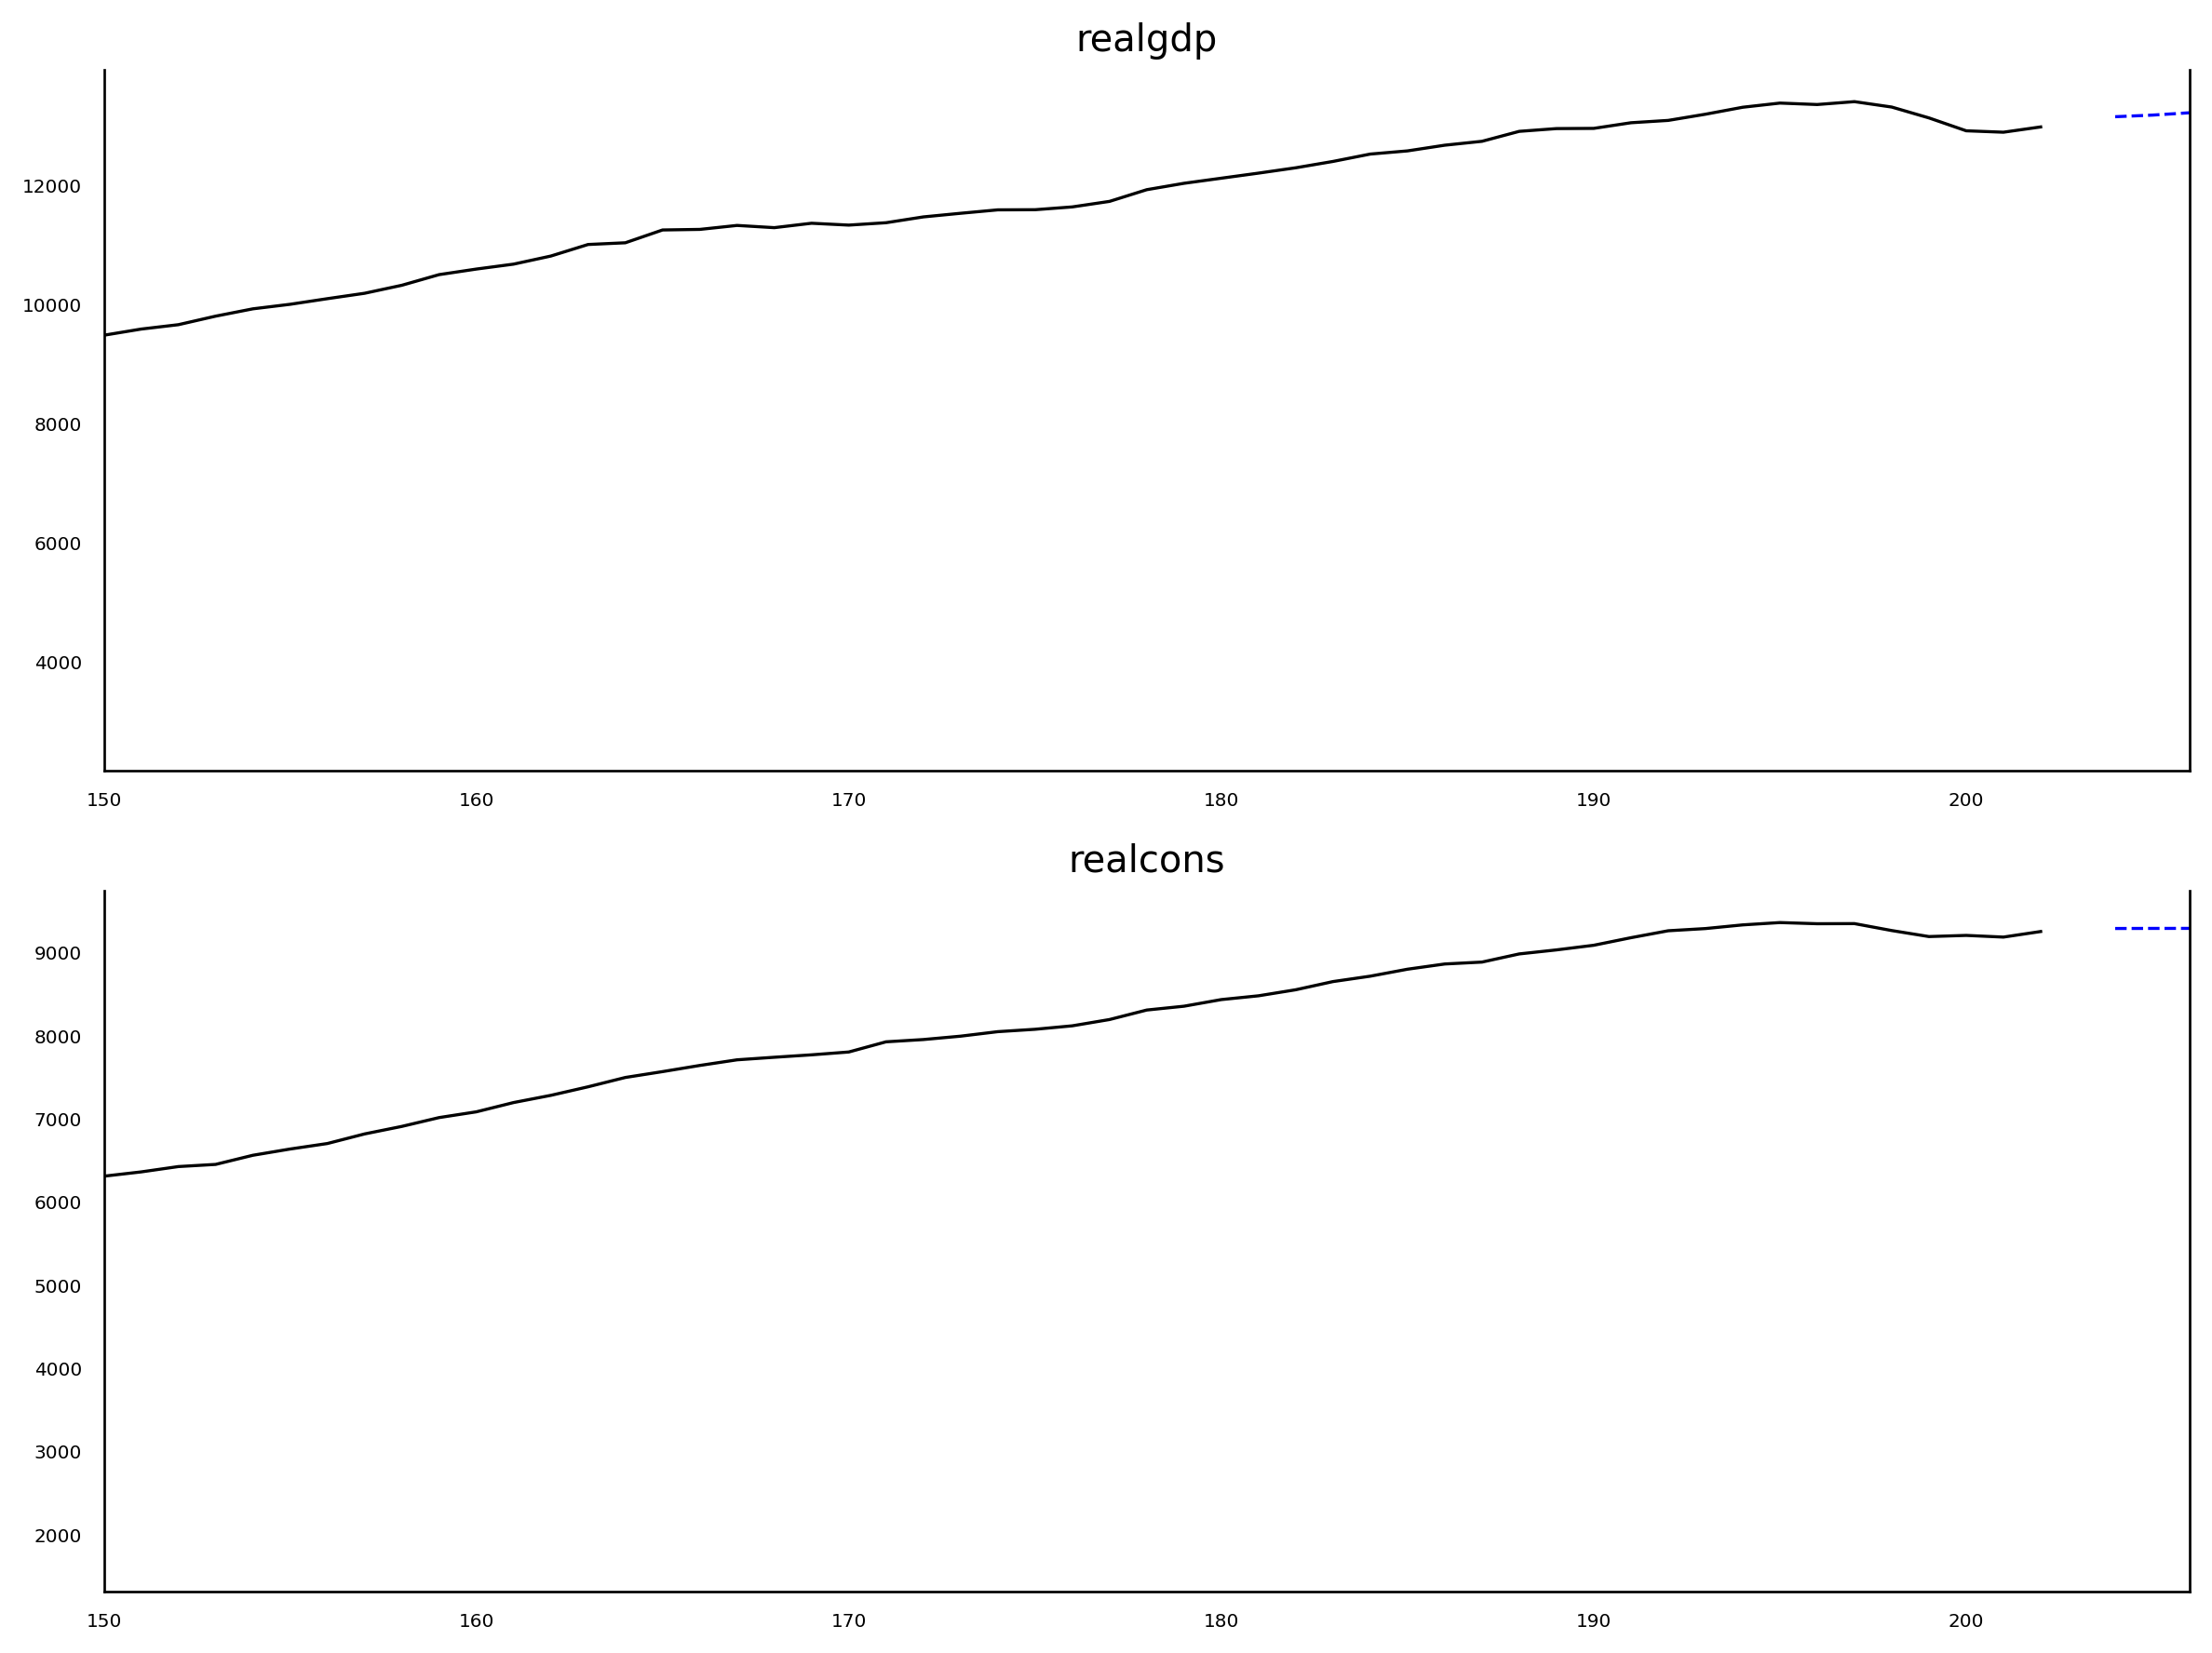

In [ ]:
n_forecast = 3
predict = res_VARMA.get_prediction(end=best_model_VARMA.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color='black', linewidth=1)
ax1.plot(idx[-n_forecast:], 
         predict.predicted_mean['realgdp'][-n_forecast:], 
         color='blue', 
         ls='--',
         linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150, 206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'], color='black', linewidth=1)
ax2.plot(idx[-n_forecast:], 
         predict.predicted_mean['realcons'][-n_forecast:], 
         color='blue', 
         ls='--',
         linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()

# VARMAX

In [ ]:
def optimize_VARMAX(endog, exog, parameters_list):
    """
        Returns a dataframe with (p,q) and MSE
        
        endog - the observed variable
        exog - the exogenous variables
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, exog, order=param).fit(disp=False)
        except:
            continue
    
        mse = model.mse
        results.append([param, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
endog = macro_data[['realgdp', 'realcons']][:200]

exog_cols = macro_data.columns.drop(['year', 'quarter', 'realgdp', 'realcons'])
exog = macro_data[exog_cols][:200]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters = product(p, q)
parameters_list = list(parameters)

results_df_VARMAX = optimize_VARMAX(endog, exog, parameters_list)
results_df_VARMAX

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",mse
0,"(1, 3)",2317.229219
1,"(3, 3)",2322.505560
2,"(2, 3)",2343.276506
3,"(3, 2)",2363.608499
4,"(2, 2)",2396.229895
5,"(1, 2)",2431.296383
6,"(3, 1)",2465.099560
7,"(3, 0)",2519.681336
8,"(2, 1)",2538.990243
9,"(1, 1)",2575.697668


In [ ]:
best_model_VARMAX = VARMAX(endog, exog, order=(1,3))
res_VARMAX = best_model_VARMAX.fit(disp=False)
print(res_VARMAX.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  200
Model:                         VARMAX(1,3)   Log Likelihood               -1949.914
                               + intercept   AIC                           3981.829
Date:                     Wed, 22 Jun 2022   BIC                           4117.060
Time:                             12:59:08   HQIC                          4036.555
Sample:                                  0                                         
                                     - 200                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             3.11, 0.20   Jarque-Bera (JB):           7.00, 2.85
Prob(Q):                        0.08, 0.66   Prob(JB):                   0.03, 0.24
Heteroskedasticity (H):         1.59, 2.50   Skew:                       0.1

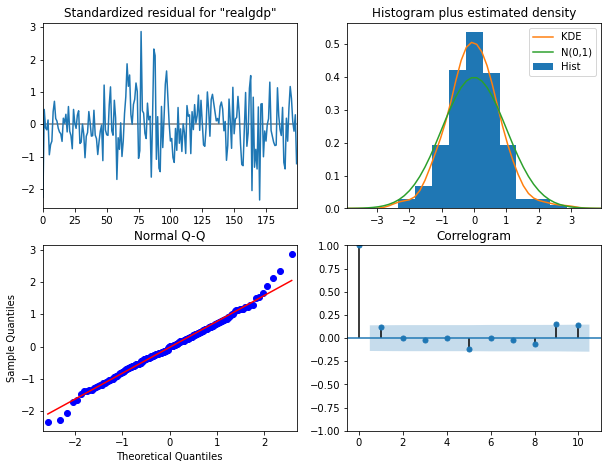

In [ ]:
res_VARMAX.plot_diagnostics();

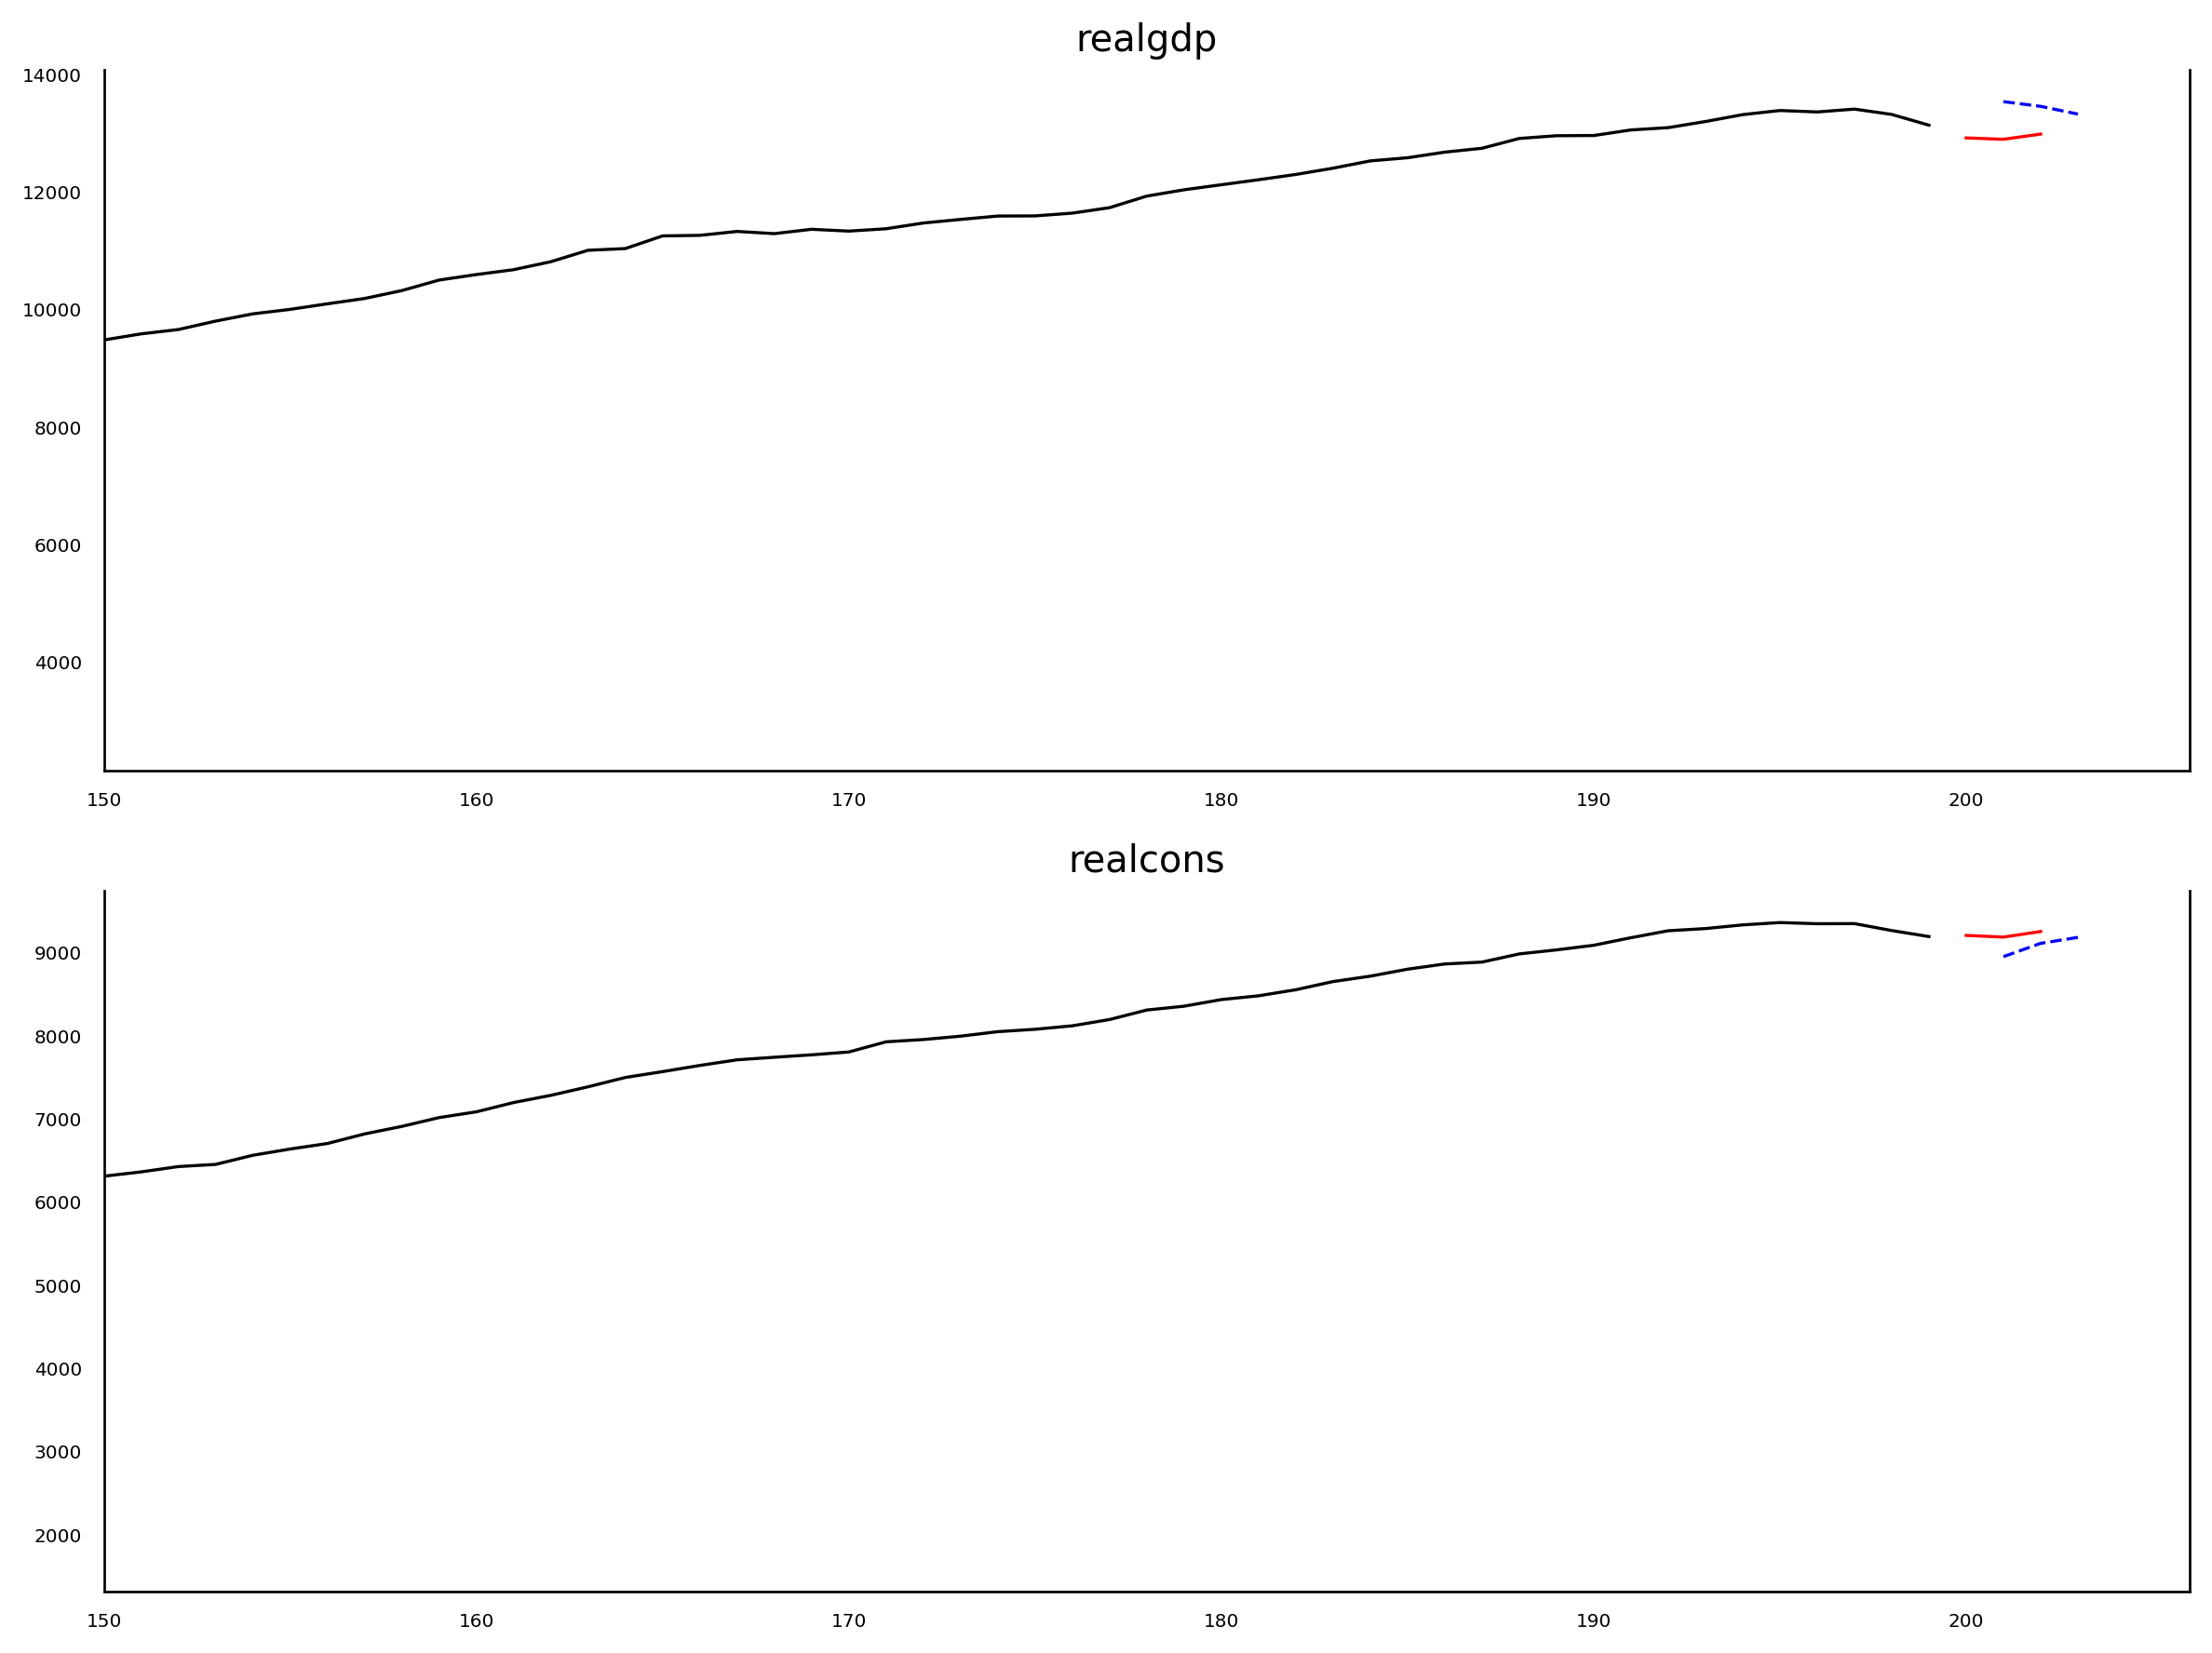

In [ ]:
n_forecast = 3
predict = res_VARMAX.get_prediction(end=best_model_VARMAX.nobs + n_forecast, exog = exog.iloc[-4:])
idx = np.arange(len(predict.predicted_mean))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'][:200], color='black', linewidth=1)
ax1.plot(macro_data['realgdp'][200:], color='red', linewidth=1)
ax1.plot(idx[-n_forecast:], 
         predict.predicted_mean['realgdp'][-n_forecast:], 
         color='blue', 
         ls='--',
         linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150, 206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'][:200], color='black', linewidth=1)
ax2.plot(macro_data['realcons'][200:], color='red', linewidth=1)
ax2.plot(idx[-n_forecast:], 
         predict.predicted_mean['realcons'][-n_forecast:], 
         color='blue', 
         ls='--',
         linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()